In [5]:
%matplotlib inline
from ENet import enet, train_utils, train
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils import to_categorical
from keras import callbacks
import numpy as np
import os


#### Getting the data from file to training format

https://arxiv.org/abs/1606.02147


The very first step is just the data from the folders into the generator that can spit out a bunch of images in batches of a specified size. For more information look at the actual .py files for this code. I've given pretty thorough documenation on what actually happens.

The main idea is that we want to produce X,Y where X is our training vector and Y is our label. More specifically, X is our array of an image and Y is the labels for each pixel.

If X is a 256,256 image with RGB channels it will have dimensions (256,256,3). This means our Y matrix will be (256*256, 2) since every pixel will be classified into one of the two classes (focal leaf/not leaf). So it is the generator's job to take our images, both labeled and original, and produce these matrices. This is done by looking at the color of the pixels and producing masks based on the things we hand labeled.

DEFINITIONS: 
- Batch size: The size of a set of data that will be read by the model. The model doesn't just take in a single image at a time, but a set of images. After each batch, the cost and error will be evaluated. There is a lot of testing to be done with this parameter, but I usually opt for 16 since that's what I saw in some tutorials. I believe the wisdom is that smaller batch size may cause more variability in updates while too large of a batch size may lose information in the individual images.

- train size: real number [0,1.0]; the ratio of images to be used for training 
- test/validation size: real number [0,1.0]; 1.0 - train size. The rest of the data not used for training will be used to evaluate the model to see how well the model generalizes


In [19]:
# Directory where we store all of the original picture
original = 'sampleData/segmentation_data/original/'
# Directory of all the images that have the pixels labeled
labeled = 'sampleData/segmentation_data/labeled/'

# create a train and validation generator. In this case I only created a training validation to show
# off the capabilities of the model on all of the data but when getting the metrics on the model
# we would pick a train_size < 1.0 and also have a valgen variable instead of '_'
traingen, _ = train.train_val_generators(original, labeled, train_size=1.0, batch_size=4)

In [7]:
# This is to store things about the model. Checkpoint just stores the model in intermediate positions
# ealy stop cuts training short so we don't have to trian if the learning has stopped e.g. stop on the 70th epoch even
# if we told the model to train for 100 epochs because the loss is not getting any smaller

storage_path = 'serialized_objects/logs/FINAL_weights_{acc:.2f}.hdf5'
checkpoint = callbacks.ModelCheckpoint(storage_path, monitor='acc', period=4, save_best_only=True, save_weights_only=True)
early_stop = callbacks.EarlyStopping(monitor='loss',min_delta=.007, patience=4, mode='min')
cbacks = [checkpoint, early_stop]

In [8]:
print 'training size:',traingen.n
print 'train batch size:', traingen.batch_size

training size: 4
train batch size: 4


### MODEL DEFINITION

In [9]:
# define the model based on the size and number of classes: in our case we know we have two classes of images while 
# The output is told to print the summary of the model. If we compare the output to the ENet definition, we can see
# that the model matches

model, name = enet.autoencoder(2, (256,256))

(TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(64)]), TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(16)]), TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(16)]), 64)
(TensorShape([Dimension(None), Dimension(64), Dimension(16), Dimension(64)]), 'pad', (0, 48))
(TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(128)]), TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(64)]), TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(64)]), 128)
(TensorShape([Dimension(None), Dimension(32), Dimension(64), Dimension(32)]), 'pad', (0, 64))
bottleneck 2.x and 3.x   
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
_____

In [14]:
# Train the model. We CAN include the validation generator here, but since we didn't initizalize it, it's not called in
# the definition of fitting the model. Read the keras/tensorflow documentation on this and talk to Ben about the
# specifics of how we vary the parameters of this e.g. steps_per_epoch and epochs and those types of things

# history = model.fit_generator(
#         generator=traingen,
#         steps_per_epoch=6,
#         epochs=100,
#         verbose=1,
#         callbacks=cbacks)

Epoch 1/100
6/6 [==============================] - 51s - loss: 0.7126 - acc: 0.5682 - mean_squared_error: 0.2528    
Epoch 2/100
6/6 [==============================] - 18s - loss: 0.6627 - acc: 0.6027 - mean_squared_error: 0.2335    
Epoch 3/100
6/6 [==============================] - 18s - loss: 0.6227 - acc: 0.6397 - mean_squared_error: 0.2169    
Epoch 4/100
6/6 [==============================] - 47s - loss: 0.5900 - acc: 0.6725 - mean_squared_error: 0.2035    
Epoch 5/100
6/6 [==============================] - 18s - loss: 0.5570 - acc: 0.7048 - mean_squared_error: 0.1897    
Epoch 6/100
6/6 [==============================] - 18s - loss: 0.5317 - acc: 0.7278 - mean_squared_error: 0.1792    
Epoch 7/100
6/6 [==============================] - 18s - loss: 0.5002 - acc: 0.7494 - mean_squared_error: 0.1664    
Epoch 8/100
6/6 [==============================] - 18s - loss: 0.4807 - acc: 0.7576 - mean_squared_error: 0.1590    
Epoch 9/100
6/6 [==============================] - 18s - loss: 0

In [10]:
# since the model weights for this dummy run of the model are already saved, we don't want to run the model again and
# we can just load the model directly
weights_path = 'serialized_objects/logs/FINAL_weights_0.92.hdf5'
model.load_weights(weights_path)

In [11]:
# given the output of the model, we want to produce a mask to reapply to another image
def output_to_mask(output, shape=(256,256), threshold=.5):
    yval = [1 if l[1] >= threshold else 0 for l in output]
    ymask = np.reshape(yval,(256,256))
    return ymask.astype(bool)

In [12]:
# usually apply the mask to a new image to see how the model does at identifying the pixels that belong to the leaf
# and those that don't, but here just to show of the capabilities of the model working at 92%, I just use one of the
# trained image. So this is obviously a little bit of an upperbound on performance. 
unseen_file = 'sampleData/segmentation_data/original/diseased_image_13.jpg'

# get the tarray (training array) of the file that we will use to show off our model. We just put it in it's own array
# because the model needs an entire batch usually and not just a single image
tarr = np.array([train_utils.get_training_image(unseen_file, (256,256))])

In [13]:
# output of the model where it's just a big matrix where each pixel is its own vector stating the class the model thinks
# the pixel belongs to based on softmax normalization so each pixel vector will sum to 1. This means we can also vary
# the threshold for a certain pixel to be in or out of the class
output = model.predict(tarr)

In [14]:
print output.shape
output

(1, 65536, 2)


array([[[ 0.9856711 ,  0.01432889],
        [ 0.98351902,  0.01648101],
        [ 0.99513298,  0.00486702],
        ..., 
        [ 0.98223132,  0.01776866],
        [ 0.98880565,  0.01119437],
        [ 0.98589987,  0.01410016]]], dtype=float32)

In [18]:
# produce a mask based on the output where threshold is right at .5, in this case but can be changed. 
ymask = output_to_mask(output[0], threshold=.5)
ymask = train_utils.smooth_mask(ymask, threshold=.1, self_weight=.01, size=11)

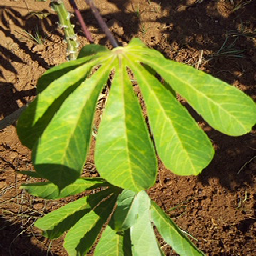

In [16]:
array_to_img(tarr[0])

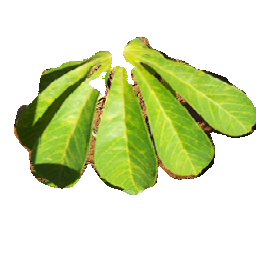

In [17]:
array_to_img(train_utils.extract_leaf(tarr[0], ymask))